In [1]:
# Importamos las bibliotecas necesarias
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import confusion_matrix
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from scipy.sparse import issparse
import warnings
warnings.filterwarnings('ignore')


# Creamos directorios para guardar resultados y gráficas
resultados_dir = './resultados_clustering'
graficas_dir = os.path.join(resultados_dir, 'graficas')

# Creamos los directorios si no existen
os.makedirs(resultados_dir, exist_ok=True)
os.makedirs(graficas_dir, exist_ok=True)

print(f"Se guardarán los resultados en: {resultados_dir}")
print(f"Se guardarán las gráficas en: {graficas_dir}")

# Definimos las rutas
ruta_datos = './Corpus-representacion'  # Ruta al corpus original
ruta_resultados = './resultados'         # Ruta donde están guardadas las representaciones

Se guardarán los resultados en: ./resultados_clustering
Se guardarán las gráficas en: ./resultados_clustering/graficas


In [2]:
# Generamos el goldstandard
def generar_goldstandard(ruta_base):
    """
    Genera el goldstandard asignando a cada documento su categoría original
    """
    documentos = []
    etiquetas = []
    
    # Recorremos todas las subcarpetas (categorías)
    for categoria in os.listdir(ruta_base):
        ruta_categoria = os.path.join(ruta_base, categoria)
        
        # Verificamos que sea un directorio
        if os.path.isdir(ruta_categoria):
            # Listamos los archivos en esta categoría
            for archivo in os.listdir(ruta_categoria):
                ruta_archivo = os.path.join(ruta_categoria, archivo)
                
                # Verificamos que sea un archivo
                if os.path.isfile(ruta_archivo):
                    documentos.append(ruta_archivo)
                    etiquetas.append(categoria)
    
    # Creamos un DataFrame con la información
    df_goldstandard = pd.DataFrame({
        'documento': documentos,
        'categoria': etiquetas
    })
    
    # Ordenamos los documentos para asegurar consistencia
    df_goldstandard = df_goldstandard.sort_values('documento').reset_index(drop=True)
    
    # Creamos un mapeo numérico de categorías para facilitar la evaluación
    categorias_unicas = sorted(set(etiquetas))
    mapeo_categorias = {cat: i for i, cat in enumerate(categorias_unicas)}
    df_goldstandard['categoria_id'] = df_goldstandard['categoria'].map(mapeo_categorias)
    
    return df_goldstandard, categorias_unicas, mapeo_categorias

Total de documentos en el goldstandard: 805
Categorías únicas: ['comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'rec.autos', 'rec.sport.hockey', 'sci.electronics', 'talk.politics.guns', 'talk.politics.mideast']
Mapeo de categorías: {'comp.sys.ibm.pc.hardware': 0, 'comp.sys.mac.hardware': 1, 'rec.autos': 2, 'rec.sport.hockey': 3, 'sci.electronics': 4, 'talk.politics.guns': 5, 'talk.politics.mideast': 6}
Goldstandard guardado en ./resultados_clustering/goldstandard.csv
Distribución de documentos por categoría:
comp.sys.ibm.pc.hardware: 124 documentos
comp.sys.mac.hardware: 146 documentos
rec.autos: 61 documentos
rec.sport.hockey: 50 documentos
sci.electronics: 211 documentos
talk.politics.guns: 141 documentos
talk.politics.mideast: 72 documentos


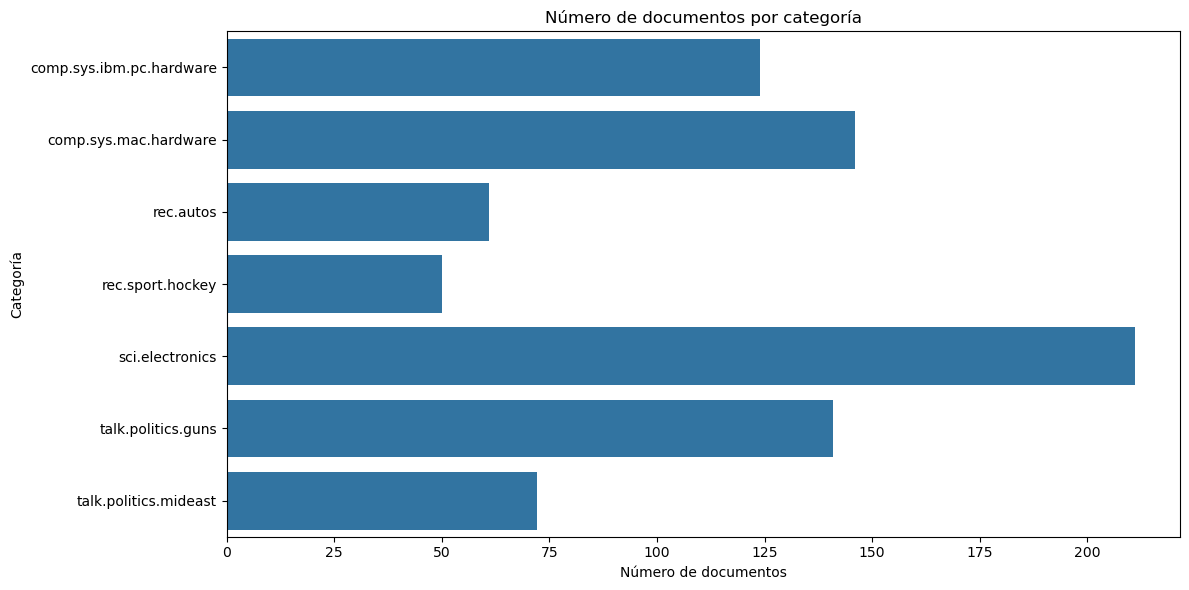

In [3]:
# Generamos el goldstandard
goldstandard, categorias_unicas, mapeo_categorias = generar_goldstandard(ruta_datos)
print(f"Total de documentos en el goldstandard: {len(goldstandard)}")
print(f"Categorías únicas: {categorias_unicas}")
print(f"Mapeo de categorías: {mapeo_categorias}")

# Guardamos el goldstandard
goldstandard.to_csv(os.path.join(resultados_dir, 'goldstandard.csv'), index=False)
print(f"Goldstandard guardado en {os.path.join(resultados_dir, 'goldstandard.csv')}")

# Veamos las primeras filas del goldstandard
goldstandard.head()

# Analizamos la distribución de documentos por categoría
distribucion = goldstandard['categoria'].value_counts().sort_index()
print("Distribución de documentos por categoría:")
for categoria, count in distribucion.items():
    print(f"{categoria}: {count} documentos")

# Visualizamos la distribución
plt.figure(figsize=(12, 6))
sns.countplot(y=goldstandard['categoria'], order=distribucion.index)
plt.title('Número de documentos por categoría')
plt.xlabel('Número de documentos')
plt.ylabel('Categoría')
plt.tight_layout()
plt.savefig(os.path.join(graficas_dir, 'distribucion_documentos.png'), dpi=150)
plt.show()

In [4]:
def cargar_representaciones(ruta_base):
    """
    Carga las representaciones TF, TF-IDF, aditiva y media generadas en la Tarea 3
    """
    print("Cargando representaciones...")
    representaciones = {}
    
    # Intentamos cargar representación TF
    try:
        rep_tf = pd.read_csv(os.path.join(ruta_base, 'representacion_tf.txt'), sep='\t')
        representaciones['TF'] = rep_tf
        print(f"Representación TF cargada: {rep_tf.shape}")
    except Exception as e:
        print(f"Error al cargar representación TF: {e}")
    
    # Intentamos cargar representación TF-IDF
    try:
        rep_tfidf = pd.read_csv(os.path.join(ruta_base, 'representacion_tfidf.txt'), sep='\t')
        representaciones['TF-IDF'] = rep_tfidf
        print(f"Representación TF-IDF cargada: {rep_tfidf.shape}")
    except Exception as e:
        print(f"Error al cargar representación TF-IDF: {e}")
    
    # Intentamos cargar representación aditiva
    try:
        rep_aditiva = np.loadtxt(os.path.join(ruta_base, 'representacion_aditiva.txt'), delimiter='\t')
        representaciones['Aditiva'] = rep_aditiva
        print(f"Representación aditiva cargada: {rep_aditiva.shape}")
    except Exception as e:
        print(f"Error al cargar representación aditiva: {e}")
    
    # Intentamos cargar representación media
    try:
        rep_media = np.loadtxt(os.path.join(ruta_base, 'representacion_media.txt'), delimiter='\t')
        representaciones['Media'] = rep_media
        print(f"Representación media cargada: {rep_media.shape}")
    except Exception as e:
        print(f"Error al cargar representación media: {e}")
    
    return representaciones

In [5]:
# Cargamos las representaciones
representaciones = cargar_representaciones(ruta_resultados)

Cargando representaciones...
Representación TF cargada: (805, 10026)
Representación TF-IDF cargada: (805, 10026)
Representación aditiva cargada: (805, 50)
Representación media cargada: (805, 50)


In [6]:
# Implementamos BCubed Precision, Recall y F-measure para evaluación externa
def bcubed_precision_recall_fscore(y_true, y_pred):
    """
    Calcula las métricas BCubed Precision, Recall y F-measure
    
    Referencia: "A Comparison of Extrinsic Clustering Evaluation Metrics Based on Formal Constraints" 
    por Amigó et al.
    """
    # Convertimos a arrays numpy
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    
    # Creamos un array de índices
    n_items = len(y_true)
    items = np.arange(n_items)
    
    # Inicializamos contadores
    precision_sum = 0.0
    recall_sum = 0.0
    
    # Para cada item
    for i in range(n_items):
        # Encontramos los elementos en el mismo cluster según la predicción
        pred_cluster = items[y_pred == y_pred[i]]
        n_pred_cluster = len(pred_cluster)
        
        # Encontramos los elementos en la misma clase según el gold standard
        true_cluster = items[y_true == y_true[i]]
        n_true_cluster = len(true_cluster)
        
        # Contamos los elementos que están tanto en el mismo cluster como en la misma clase
        n_correct = np.sum(np.in1d(pred_cluster, true_cluster))
        
        # Calculamos la precisión y cobertura para este item
        precision = n_correct / n_pred_cluster if n_pred_cluster > 0 else 0
        recall = n_correct / n_true_cluster if n_true_cluster > 0 else 0
        
        precision_sum += precision
        recall_sum += recall
    
    # Calculamos los promedios
    precision = precision_sum / n_items
    recall = recall_sum / n_items
    
    # Calculamos la medida F
    fscore = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, fscore

In [7]:
def aplicar_clustering(representaciones, goldstandard, num_clusters=7):
    """
    Aplica los algoritmos de clustering a cada representación y evalúa los resultados
    """
    resultados = []
    matrices_confusion = {}
    etiquetas_clustering = {}
    etiquetas_reales = goldstandard['categoria_id'].values
    
    for nombre_rep, rep in representaciones.items():
        print(f"\nProcesando representación: {nombre_rep}")
        
        # Preparamos los datos
        if isinstance(rep, pd.DataFrame):
            datos = rep.values
        else:
            datos = rep
        
        # Para las representaciones basadas en word embeddings, normalizamos los datos
        if nombre_rep in ['Aditiva', 'Media']:
            scaler = StandardScaler()
            datos = scaler.fit_transform(datos)
        
        # Aplicamos K-means
        print("Aplicando K-means...")
        kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
        etiquetas_kmeans = kmeans.fit_predict(datos)
        etiquetas_clustering[f"{nombre_rep}_Kmeans"] = etiquetas_kmeans
        
        # Evaluamos K-means
        ari_kmeans = adjusted_rand_score(etiquetas_reales, etiquetas_kmeans)
        precision_kmeans, recall_kmeans, fscore_kmeans = bcubed_precision_recall_fscore(etiquetas_reales, etiquetas_kmeans)
        
        print(f"K-means - ARI: {ari_kmeans:.4f}, BCubed Precision: {precision_kmeans:.4f}, BCubed Recall: {recall_kmeans:.4f}, BCubed F-score: {fscore_kmeans:.4f}")
        
        # Guardamos los resultados de K-means
        resultados.append({
            'Representación': nombre_rep,
            'Algoritmo': 'K-means',
            'ARI': ari_kmeans,
            'BCubed Precision': precision_kmeans,
            'BCubed Recall': recall_kmeans,
            'BCubed F-score': fscore_kmeans
        })
        
        # Guardamos la matriz de confusión para K-means
        matrices_confusion[f"{nombre_rep}_Kmeans"] = confusion_matrix(etiquetas_reales, etiquetas_kmeans)
        
        # Aplicamos Clustering Jerárquico Aglomerativo
        print("Aplicando Clustering Jerárquico Aglomerativo...")
        agglom = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward')
        etiquetas_agglom = agglom.fit_predict(datos)
        etiquetas_clustering[f"{nombre_rep}_Jerarquico"] = etiquetas_agglom
        
        # Evaluamos Clustering Jerárquico
        ari_agglom = adjusted_rand_score(etiquetas_reales, etiquetas_agglom)
        precision_agglom, recall_agglom, fscore_agglom = bcubed_precision_recall_fscore(etiquetas_reales, etiquetas_agglom)
        
        print(f"Jerárquico - ARI: {ari_agglom:.4f}, BCubed Precision: {precision_agglom:.4f}, BCubed Recall: {recall_agglom:.4f}, BCubed F-score: {fscore_agglom:.4f}")
        
        # Guardamos los resultados del Clustering Jerárquico
        resultados.append({
            'Representación': nombre_rep,
            'Algoritmo': 'Jerárquico',
            'ARI': ari_agglom,
            'BCubed Precision': precision_agglom,
            'BCubed Recall': recall_agglom,
            'BCubed F-score': fscore_agglom
        })
        
        # Guardamos la matriz de confusión para Clustering Jerárquico
        matrices_confusion[f"{nombre_rep}_Jerarquico"] = confusion_matrix(etiquetas_reales, etiquetas_agglom)
    
    # Convertimos los resultados a DataFrame
    df_resultados = pd.DataFrame(resultados)
    
    # Guardamos las etiquetas de clustering
    for nombre, etiquetas in etiquetas_clustering.items():
        np.savetxt(os.path.join(resultados_dir, f'etiquetas_{nombre}.txt'), etiquetas, fmt='%d')
    
    return df_resultados, matrices_confusion


Procesando representación: TF
Aplicando K-means...
K-means - ARI: 0.0053, BCubed Precision: 0.1860, BCubed Recall: 0.9550, BCubed F-score: 0.3114
Aplicando Clustering Jerárquico Aglomerativo...
Jerárquico - ARI: 0.0090, BCubed Precision: 0.1904, BCubed Recall: 0.9243, BCubed F-score: 0.3158

Procesando representación: TF-IDF
Aplicando K-means...
K-means - ARI: 0.1017, BCubed Precision: 0.3039, BCubed Recall: 0.3419, BCubed F-score: 0.3218
Aplicando Clustering Jerárquico Aglomerativo...
Jerárquico - ARI: 0.0901, BCubed Precision: 0.2906, BCubed Recall: 0.6263, BCubed F-score: 0.3970

Procesando representación: Aditiva
Aplicando K-means...
K-means - ARI: 0.0069, BCubed Precision: 0.1946, BCubed Recall: 0.5788, BCubed F-score: 0.2912
Aplicando Clustering Jerárquico Aglomerativo...
Jerárquico - ARI: 0.0633, BCubed Precision: 0.2124, BCubed Recall: 0.7056, BCubed F-score: 0.3265

Procesando representación: Media
Aplicando K-means...
K-means - ARI: 0.0899, BCubed Precision: 0.2580, BCubed R

,Representación,Algoritmo,ARI,BCubed Precision,BCubed Recall,BCubed F-score
0,TF,K-means,0.005338,0.186050,0.954992,0.311427
1,TF,Jerárquico,0.009005,0.190445,0.924308,0.315818
2,TF-IDF,K-means,0.101724,0.303909,0.341868,0.321773
3,TF-IDF,Jerárquico,0.090093,0.290637,0.626286,0.397027
4,Aditiva,K-means,0.006910,0.194560,0.578845,0.291232
5,Aditiva,Jerárquico,0.063321,0.212426,0.705625,0.326547
6,Media,K-means,0.089940,0.257965,0.275345,0.266372
7,Media,Jerárquico,0.119121,0.289528,0.376853,0.327469


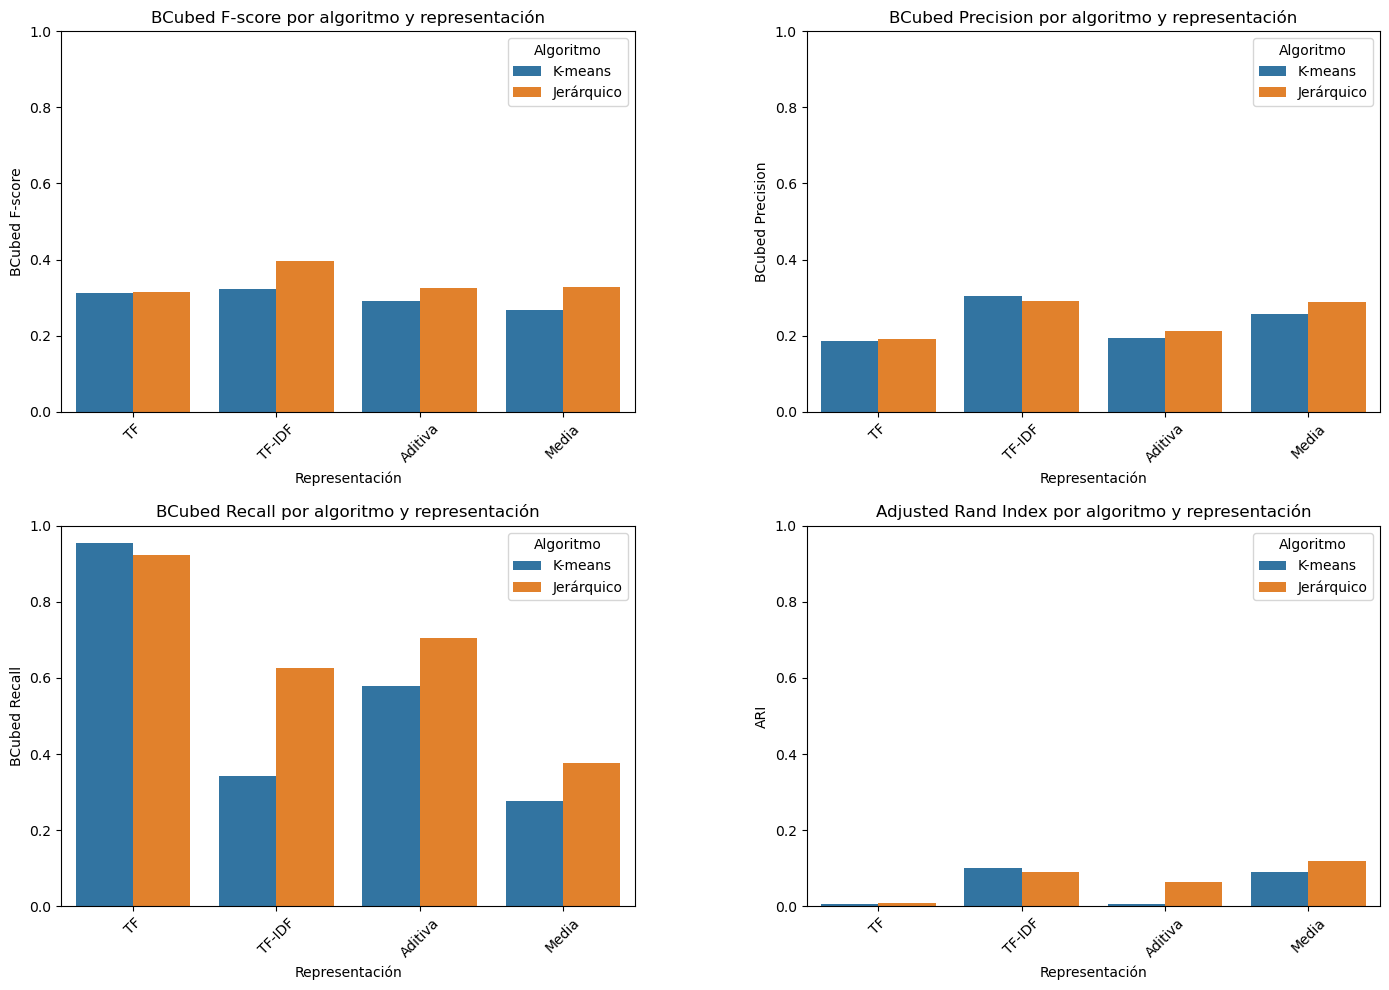


Mejor combinación según BCubed F-score:
Representación: TF-IDF
Algoritmo: Jerárquico
BCubed F-score: 0.3970
BCubed Precision: 0.2906
BCubed Recall: 0.6263
ARI: 0.0901


In [8]:
# Aplicamos clustering a todas las representaciones
df_resultados, matrices_confusion = aplicar_clustering(representaciones, goldstandard)

# Guardamos los resultados en CSV
df_resultados.to_csv(os.path.join(resultados_dir, 'resultados_clustering.csv'), index=False)
print(f"Resultados guardados en {os.path.join(resultados_dir, 'resultados_clustering.csv')}")

# Mostramos la tabla completa de resultados
print("Resultados completos:")
display(df_resultados)

# Visualizamos las métricas por algoritmo y representación
plt.figure(figsize=(14, 10))

# BCubed F-score
plt.subplot(2, 2, 1)
sns.barplot(x='Representación', y='BCubed F-score', hue='Algoritmo', data=df_resultados)
plt.title('BCubed F-score por algoritmo y representación')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()

# BCubed Precision
plt.subplot(2, 2, 2)
sns.barplot(x='Representación', y='BCubed Precision', hue='Algoritmo', data=df_resultados)
plt.title('BCubed Precision por algoritmo y representación')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()

# BCubed Recall
plt.subplot(2, 2, 3)
sns.barplot(x='Representación', y='BCubed Recall', hue='Algoritmo', data=df_resultados)
plt.title('BCubed Recall por algoritmo y representación')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()

# ARI
plt.subplot(2, 2, 4)
sns.barplot(x='Representación', y='ARI', hue='Algoritmo', data=df_resultados)
plt.title('Adjusted Rand Index por algoritmo y representación')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()

plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.savefig(os.path.join(graficas_dir, 'metricas_comparativas.png'), dpi=150)
plt.show()

# Encontramos la mejor combinación
mejor_combinacion = df_resultados.loc[df_resultados['BCubed F-score'].idxmax()]
print(f"\nMejor combinación según BCubed F-score:")
print(f"Representación: {mejor_combinacion['Representación']}")
print(f"Algoritmo: {mejor_combinacion['Algoritmo']}")
print(f"BCubed F-score: {mejor_combinacion['BCubed F-score']:.4f}")
print(f"BCubed Precision: {mejor_combinacion['BCubed Precision']:.4f}")
print(f"BCubed Recall: {mejor_combinacion['BCubed Recall']:.4f}")
print(f"ARI: {mejor_combinacion['ARI']:.4f}")

# Guardamos la información de la mejor combinación
with open(os.path.join(resultados_dir, 'mejor_combinacion.txt'), 'w') as f:
    f.write(f"Representación: {mejor_combinacion['Representación']}\n")
    f.write(f"Algoritmo: {mejor_combinacion['Algoritmo']}\n")
    f.write(f"BCubed F-score: {mejor_combinacion['BCubed F-score']:.4f}\n")
    f.write(f"BCubed Precision: {mejor_combinacion['BCubed Precision']:.4f}\n")
    f.write(f"BCubed Recall: {mejor_combinacion['BCubed Recall']:.4f}\n")
    f.write(f"ARI: {mejor_combinacion['ARI']:.4f}\n")

In [9]:
def visualizar_matriz_confusion(matriz, titulo, categorias, guardar=False, ruta_guardado=None):
    """
    Visualiza una matriz de confusión para el análisis de clustering
    """
    plt.figure(figsize=(12, 10))
    sns.heatmap(matriz, annot=True, fmt='d', cmap='Blues', 
                xticklabels=[f'Cluster {i}' for i in range(matriz.shape[1])],
                yticklabels=categorias)
    plt.title(titulo)
    plt.xlabel('Clusters predichos')
    plt.ylabel('Categorías reales')
    plt.tight_layout()
    
    if guardar and ruta_guardado:
        plt.savefig(ruta_guardado, dpi=150)
        print(f"Matriz de confusión guardada en {ruta_guardado}")
    
    plt.show()
    
    # Análisis de correspondencia entre clusters y categorías
    print(f"\nAnálisis de la matriz de confusión para {titulo}:")
    
    # Para cada cluster, encontramos la categoría más representada
    cluster_analisis = []
    for cluster in range(matriz.shape[1]):
        max_categoria_idx = np.argmax(matriz[:, cluster])
        max_categoria = categorias[max_categoria_idx]
        porcentaje = matriz[max_categoria_idx, cluster] / matriz[:, cluster].sum() * 100
        print(f"Cluster {cluster} corresponde principalmente a '{max_categoria}' ({porcentaje:.1f}% de los documentos en este cluster)")
        cluster_analisis.append({
            'Cluster': cluster,
            'Categoría principal': max_categoria,
            'Porcentaje': porcentaje
        })
    
    # Para cada categoría, analizamos su distribución entre clusters
    categoria_analisis = []
    print("\nDistribución de categorías entre clusters:")
    for i, categoria in enumerate(categorias):
        total_cat = matriz[i, :].sum()
        if total_cat > 0:
            max_cluster = np.argmax(matriz[i, :])
            porcentaje = matriz[i, max_cluster] / total_cat * 100
            dispersión = 1 - (matriz[i, max_cluster] / total_cat)
            print(f"Categoría '{categoria}': {porcentaje:.1f}% en Cluster {max_cluster}, dispersión: {dispersión:.2f}")
            
            categoria_info = {
                'Categoría': categoria,
                'Cluster principal': max_cluster,
                'Porcentaje': porcentaje,
                'Dispersión': dispersión,
                'Distribución detallada': []
            }
            
            # Si hay mucha dispersión, analizamos los principales clusters
            if dispersión > 0.4:  # Umbral arbitrario para 'alta' dispersión
                print("  Distribución detallada:")
                indices_ordenados = np.argsort(-matriz[i, :])
                for j in indices_ordenados[:3]:  # Top 3 clusters
                    if matriz[i, j] > 0:
                        detalle = f"Cluster {j}: {matriz[i, j]} documentos ({matriz[i, j]/total_cat*100:.1f}%)"
                        print(f"    {detalle}")
                        categoria_info['Distribución detallada'].append(detalle)
            
            categoria_analisis.append(categoria_info)
    
    # Guardamos el análisis en formato CSV
    if guardar:
        df_cluster = pd.DataFrame(cluster_analisis)
        df_categoria = pd.DataFrame(categoria_analisis)
        
        # Eliminamos la columna de distribución detallada para el CSV (es una lista)
        df_categoria_csv = df_categoria.drop(columns=['Distribución detallada'])
        
        nombre_base = os.path.splitext(os.path.basename(ruta_guardado))[0]
        df_cluster.to_csv(os.path.join(resultados_dir, f'{nombre_base}_cluster_analisis.csv'), index=False)
        df_categoria_csv.to_csv(os.path.join(resultados_dir, f'{nombre_base}_categoria_analisis.csv'), index=False)
        
        # Guardamos la distribución detallada en un archivo de texto
        with open(os.path.join(resultados_dir, f'{nombre_base}_distribucion_detallada.txt'), 'w') as f:
            for cat_info in categoria_analisis:
                if cat_info['Distribución detallada']:
                    f.write(f"Categoría '{cat_info['Categoría']}':\n")
                    for detalle in cat_info['Distribución detallada']:
                        f.write(f"  {detalle}\n")
                    f.write("\n")
    
    return cluster_analisis, categoria_analisis

Matriz de confusión guardada en ./resultados_clustering/graficas/matriz_confusion_mejor.png


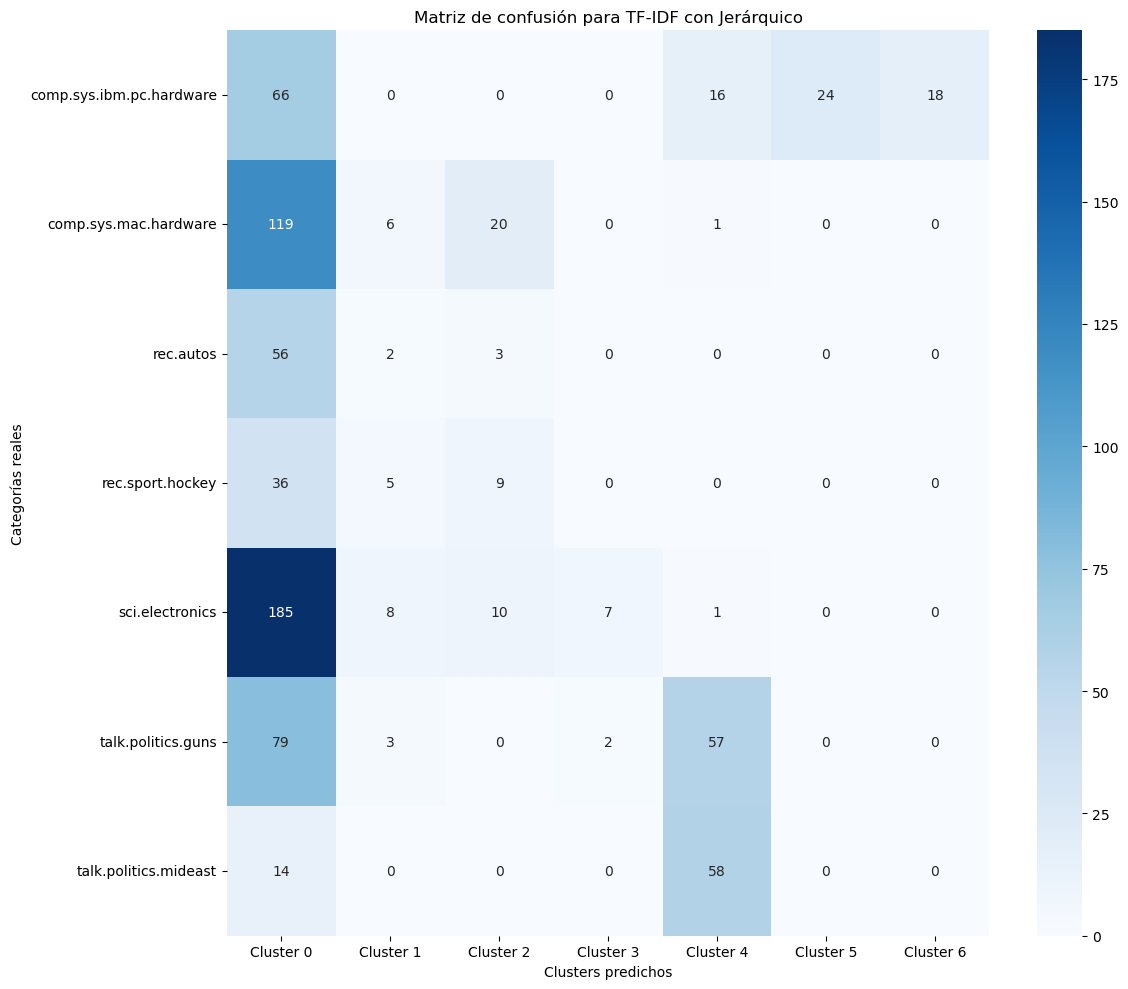


Análisis de la matriz de confusión para Matriz de confusión para TF-IDF con Jerárquico:
Cluster 0 corresponde principalmente a 'sci.electronics' (33.3% de los documentos en este cluster)
Cluster 1 corresponde principalmente a 'sci.electronics' (33.3% de los documentos en este cluster)
Cluster 2 corresponde principalmente a 'comp.sys.mac.hardware' (47.6% de los documentos en este cluster)
Cluster 3 corresponde principalmente a 'sci.electronics' (77.8% de los documentos en este cluster)
Cluster 4 corresponde principalmente a 'talk.politics.mideast' (43.6% de los documentos en este cluster)
Cluster 5 corresponde principalmente a 'comp.sys.ibm.pc.hardware' (100.0% de los documentos en este cluster)
Cluster 6 corresponde principalmente a 'comp.sys.ibm.pc.hardware' (100.0% de los documentos en este cluster)

Distribución de categorías entre clusters:
Categoría 'comp.sys.ibm.pc.hardware': 53.2% en Cluster 0, dispersión: 0.47
  Distribución detallada:
    Cluster 0: 66 documentos (53.2%)
    

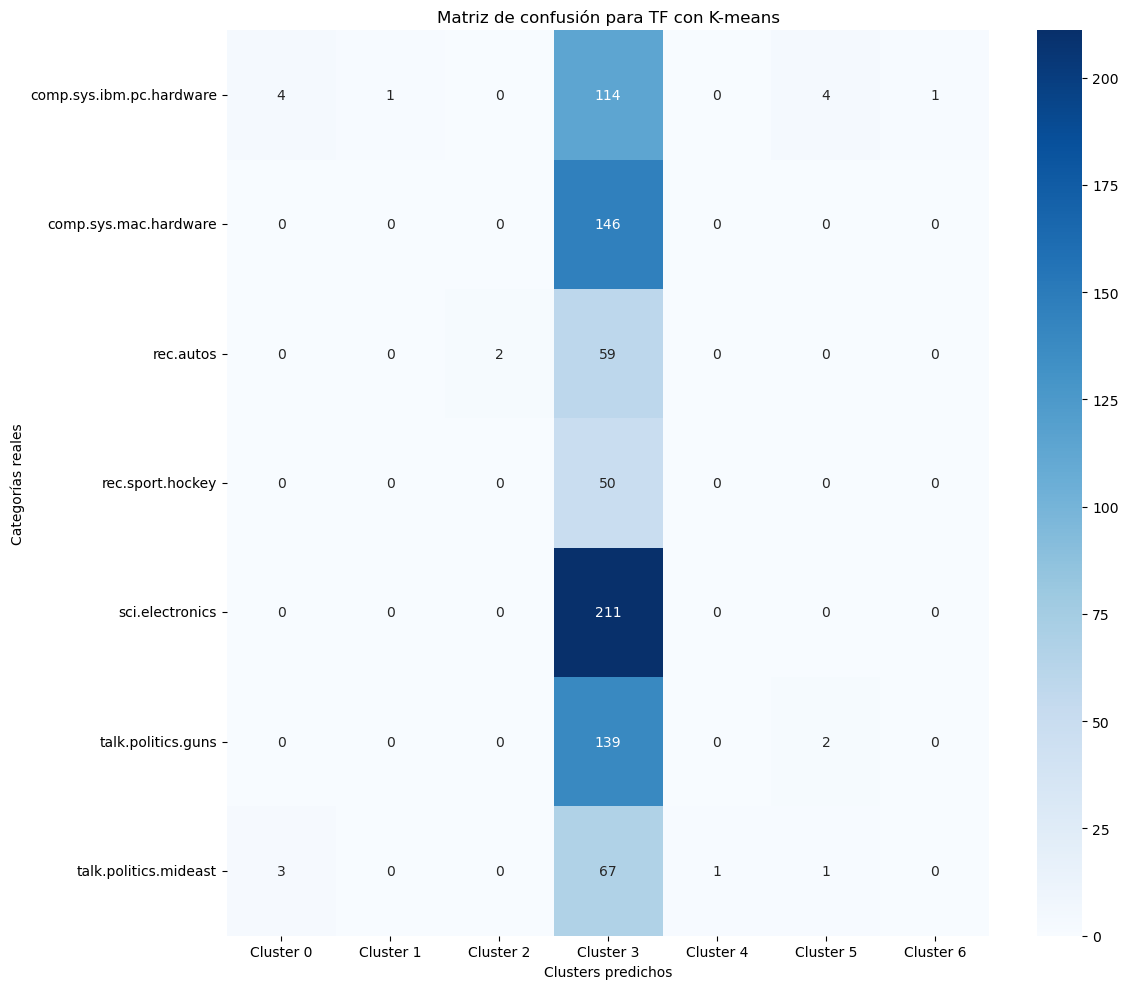


Análisis de la matriz de confusión para Matriz de confusión para TF con K-means:
Cluster 0 corresponde principalmente a 'comp.sys.ibm.pc.hardware' (57.1% de los documentos en este cluster)
Cluster 1 corresponde principalmente a 'comp.sys.ibm.pc.hardware' (100.0% de los documentos en este cluster)
Cluster 2 corresponde principalmente a 'rec.autos' (100.0% de los documentos en este cluster)
Cluster 3 corresponde principalmente a 'sci.electronics' (26.8% de los documentos en este cluster)
Cluster 4 corresponde principalmente a 'talk.politics.mideast' (100.0% de los documentos en este cluster)
Cluster 5 corresponde principalmente a 'comp.sys.ibm.pc.hardware' (57.1% de los documentos en este cluster)
Cluster 6 corresponde principalmente a 'comp.sys.ibm.pc.hardware' (100.0% de los documentos en este cluster)

Distribución de categorías entre clusters:
Categoría 'comp.sys.ibm.pc.hardware': 91.9% en Cluster 3, dispersión: 0.08
Categoría 'comp.sys.mac.hardware': 100.0% en Cluster 3, dispersión

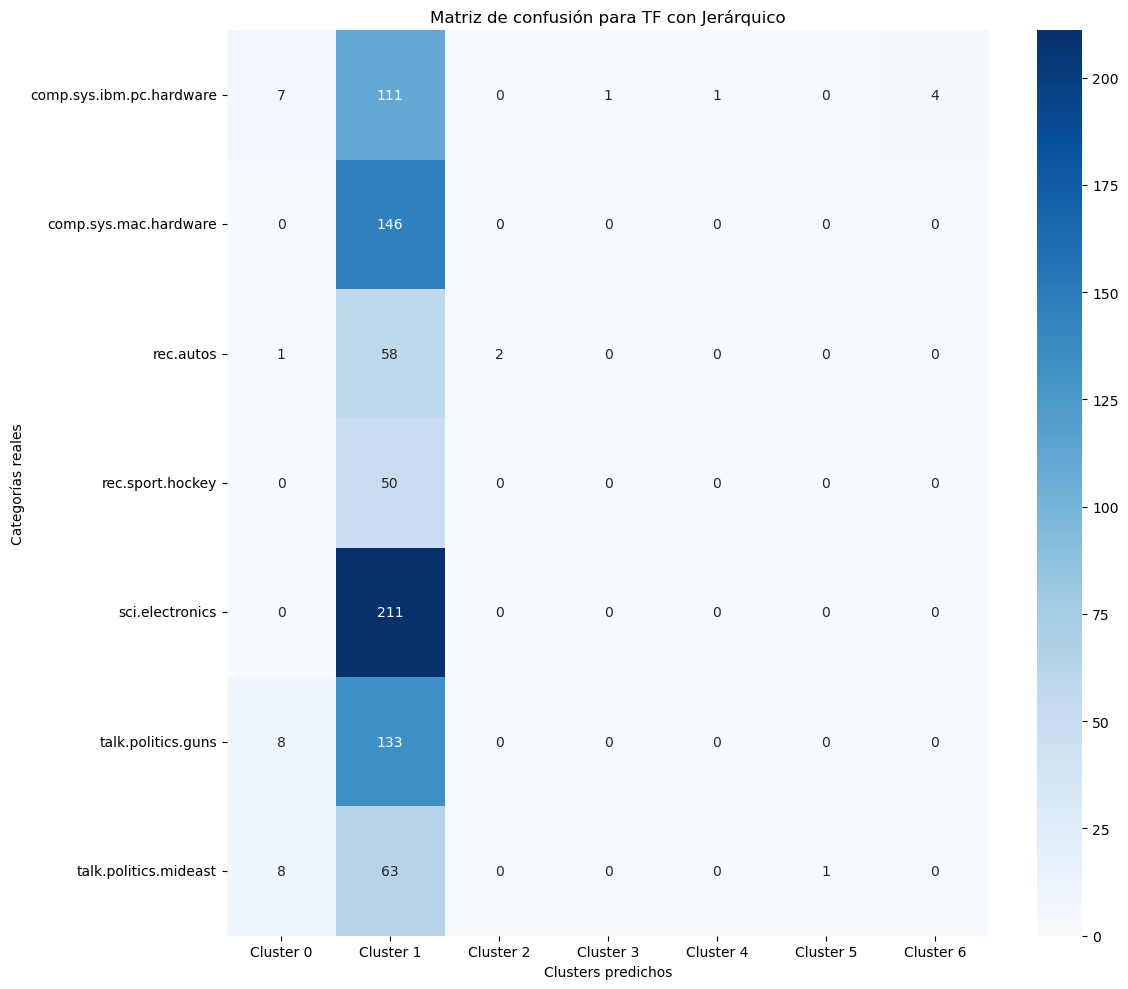


Análisis de la matriz de confusión para Matriz de confusión para TF con Jerárquico:
Cluster 0 corresponde principalmente a 'talk.politics.guns' (33.3% de los documentos en este cluster)
Cluster 1 corresponde principalmente a 'sci.electronics' (27.3% de los documentos en este cluster)
Cluster 2 corresponde principalmente a 'rec.autos' (100.0% de los documentos en este cluster)
Cluster 3 corresponde principalmente a 'comp.sys.ibm.pc.hardware' (100.0% de los documentos en este cluster)
Cluster 4 corresponde principalmente a 'comp.sys.ibm.pc.hardware' (100.0% de los documentos en este cluster)
Cluster 5 corresponde principalmente a 'talk.politics.mideast' (100.0% de los documentos en este cluster)
Cluster 6 corresponde principalmente a 'comp.sys.ibm.pc.hardware' (100.0% de los documentos en este cluster)

Distribución de categorías entre clusters:
Categoría 'comp.sys.ibm.pc.hardware': 89.5% en Cluster 1, dispersión: 0.10
Categoría 'comp.sys.mac.hardware': 100.0% en Cluster 1, dispersión: 

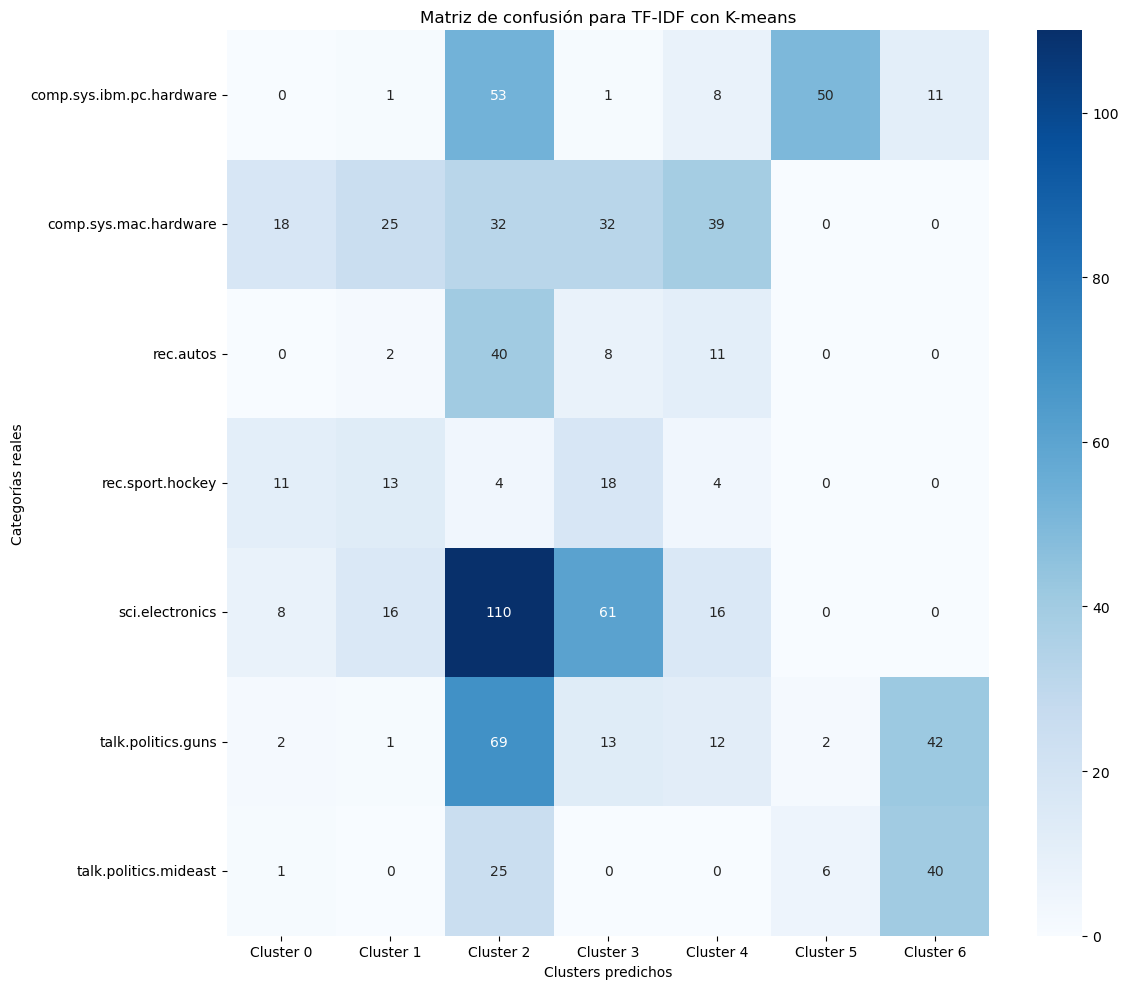


Análisis de la matriz de confusión para Matriz de confusión para TF-IDF con K-means:
Cluster 0 corresponde principalmente a 'comp.sys.mac.hardware' (45.0% de los documentos en este cluster)
Cluster 1 corresponde principalmente a 'comp.sys.mac.hardware' (43.1% de los documentos en este cluster)
Cluster 2 corresponde principalmente a 'sci.electronics' (33.0% de los documentos en este cluster)
Cluster 3 corresponde principalmente a 'sci.electronics' (45.9% de los documentos en este cluster)
Cluster 4 corresponde principalmente a 'comp.sys.mac.hardware' (43.3% de los documentos en este cluster)
Cluster 5 corresponde principalmente a 'comp.sys.ibm.pc.hardware' (86.2% de los documentos en este cluster)
Cluster 6 corresponde principalmente a 'talk.politics.guns' (45.2% de los documentos en este cluster)

Distribución de categorías entre clusters:
Categoría 'comp.sys.ibm.pc.hardware': 42.7% en Cluster 2, dispersión: 0.57
  Distribución detallada:
    Cluster 2: 53 documentos (42.7%)
    Clust

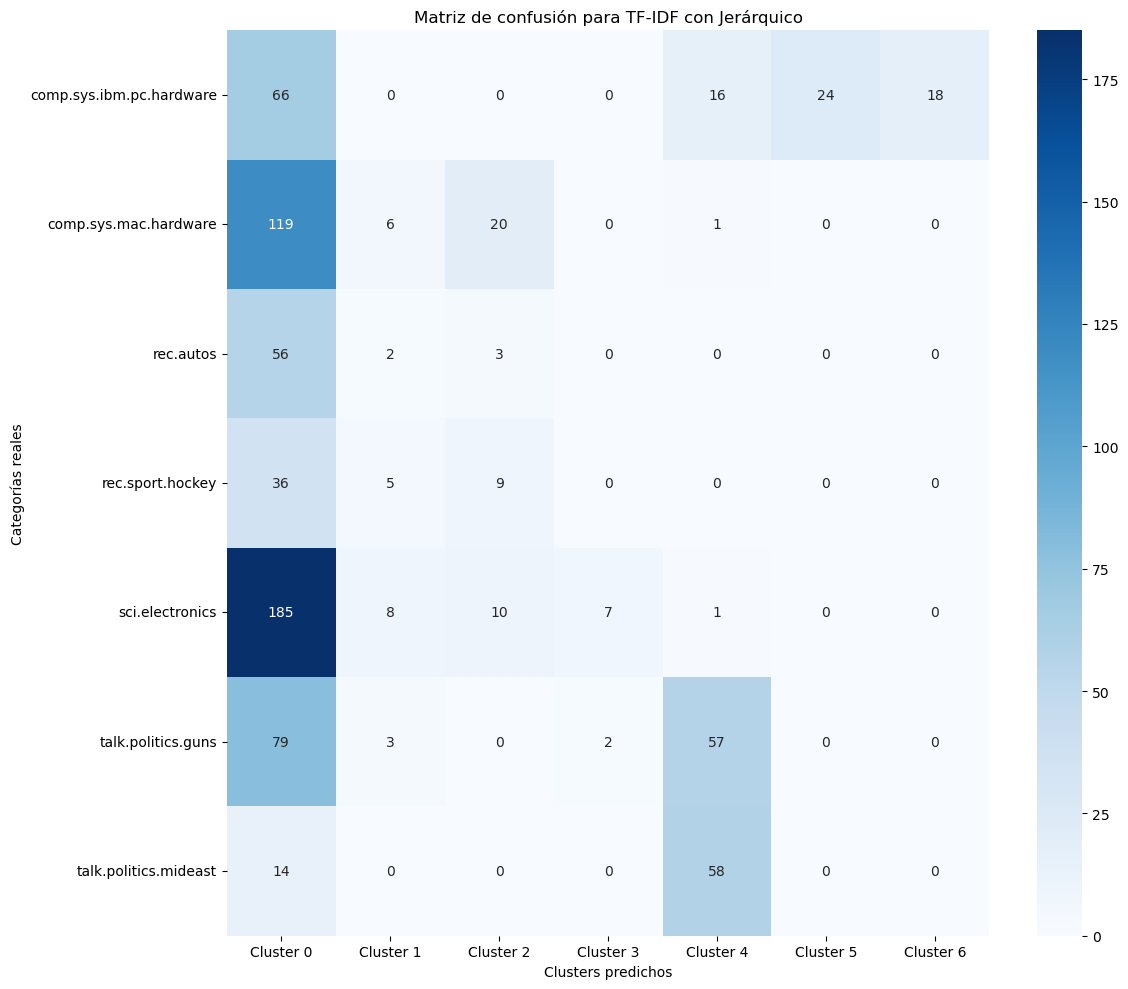


Análisis de la matriz de confusión para Matriz de confusión para TF-IDF con Jerárquico:
Cluster 0 corresponde principalmente a 'sci.electronics' (33.3% de los documentos en este cluster)
Cluster 1 corresponde principalmente a 'sci.electronics' (33.3% de los documentos en este cluster)
Cluster 2 corresponde principalmente a 'comp.sys.mac.hardware' (47.6% de los documentos en este cluster)
Cluster 3 corresponde principalmente a 'sci.electronics' (77.8% de los documentos en este cluster)
Cluster 4 corresponde principalmente a 'talk.politics.mideast' (43.6% de los documentos en este cluster)
Cluster 5 corresponde principalmente a 'comp.sys.ibm.pc.hardware' (100.0% de los documentos en este cluster)
Cluster 6 corresponde principalmente a 'comp.sys.ibm.pc.hardware' (100.0% de los documentos en este cluster)

Distribución de categorías entre clusters:
Categoría 'comp.sys.ibm.pc.hardware': 53.2% en Cluster 0, dispersión: 0.47
  Distribución detallada:
    Cluster 0: 66 documentos (53.2%)
    

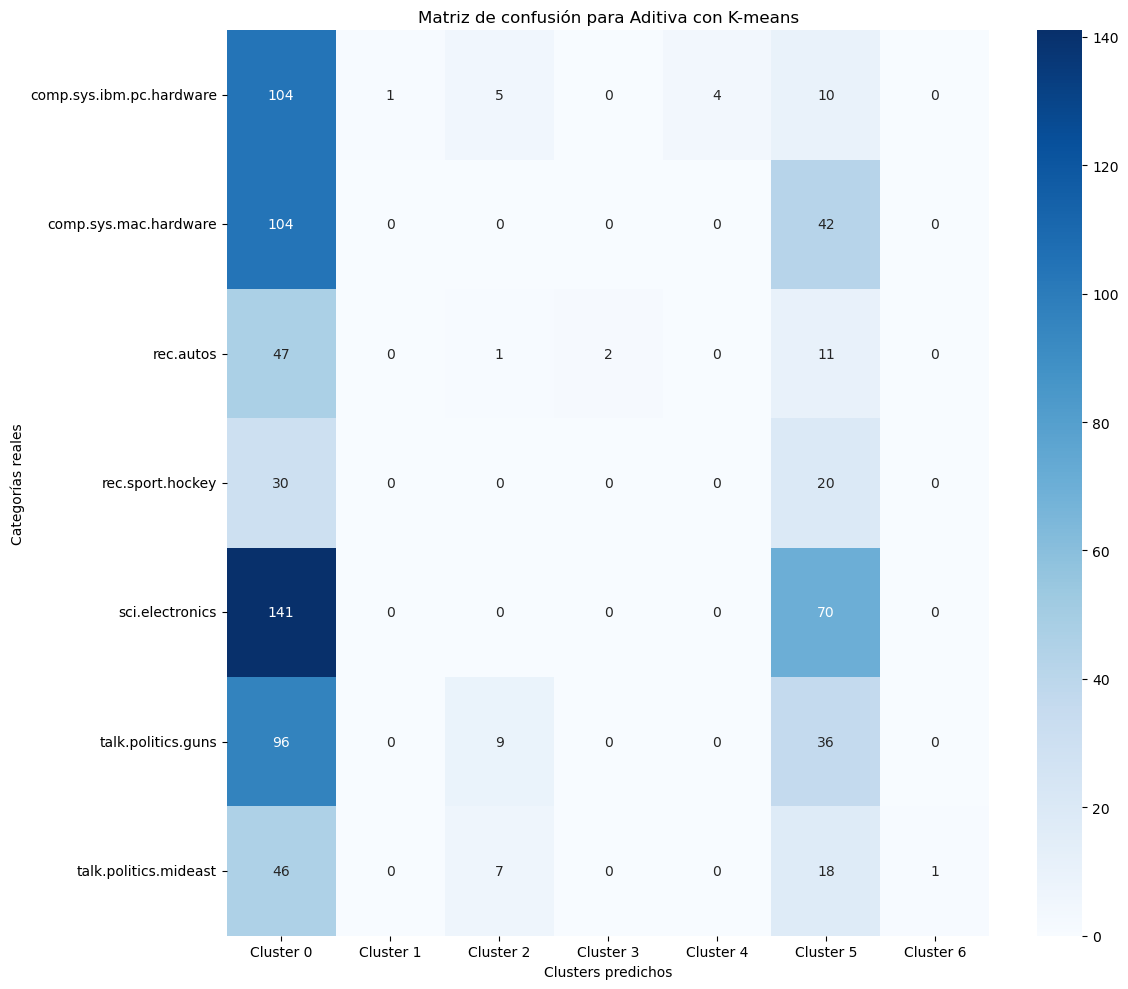


Análisis de la matriz de confusión para Matriz de confusión para Aditiva con K-means:
Cluster 0 corresponde principalmente a 'sci.electronics' (24.8% de los documentos en este cluster)
Cluster 1 corresponde principalmente a 'comp.sys.ibm.pc.hardware' (100.0% de los documentos en este cluster)
Cluster 2 corresponde principalmente a 'talk.politics.guns' (40.9% de los documentos en este cluster)
Cluster 3 corresponde principalmente a 'rec.autos' (100.0% de los documentos en este cluster)
Cluster 4 corresponde principalmente a 'comp.sys.ibm.pc.hardware' (100.0% de los documentos en este cluster)
Cluster 5 corresponde principalmente a 'sci.electronics' (33.8% de los documentos en este cluster)
Cluster 6 corresponde principalmente a 'talk.politics.mideast' (100.0% de los documentos en este cluster)

Distribución de categorías entre clusters:
Categoría 'comp.sys.ibm.pc.hardware': 83.9% en Cluster 0, dispersión: 0.16
Categoría 'comp.sys.mac.hardware': 71.2% en Cluster 0, dispersión: 0.29
Cate

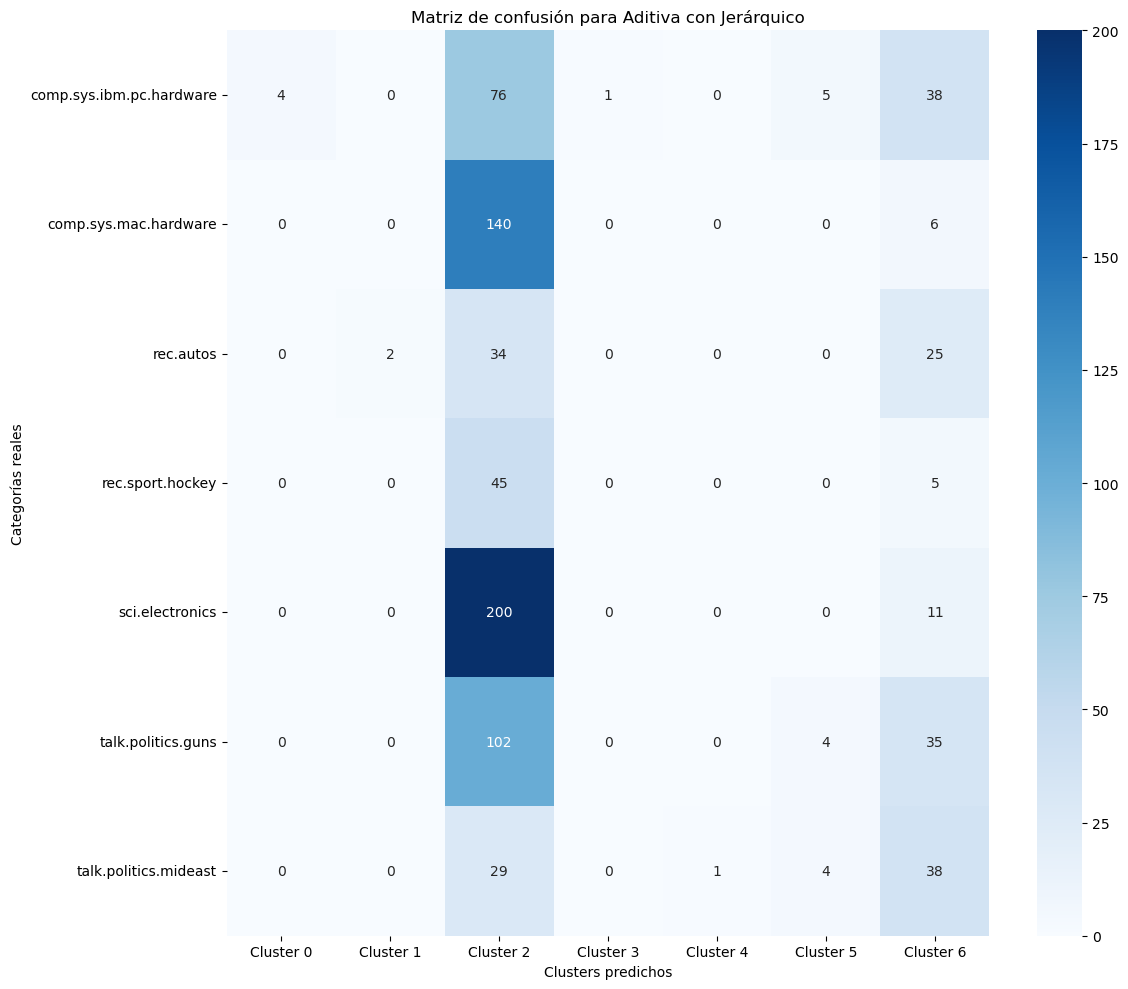


Análisis de la matriz de confusión para Matriz de confusión para Aditiva con Jerárquico:
Cluster 0 corresponde principalmente a 'comp.sys.ibm.pc.hardware' (100.0% de los documentos en este cluster)
Cluster 1 corresponde principalmente a 'rec.autos' (100.0% de los documentos en este cluster)
Cluster 2 corresponde principalmente a 'sci.electronics' (31.9% de los documentos en este cluster)
Cluster 3 corresponde principalmente a 'comp.sys.ibm.pc.hardware' (100.0% de los documentos en este cluster)
Cluster 4 corresponde principalmente a 'talk.politics.mideast' (100.0% de los documentos en este cluster)
Cluster 5 corresponde principalmente a 'comp.sys.ibm.pc.hardware' (38.5% de los documentos en este cluster)
Cluster 6 corresponde principalmente a 'comp.sys.ibm.pc.hardware' (24.1% de los documentos en este cluster)

Distribución de categorías entre clusters:
Categoría 'comp.sys.ibm.pc.hardware': 61.3% en Cluster 2, dispersión: 0.39
Categoría 'comp.sys.mac.hardware': 95.9% en Cluster 2, dis

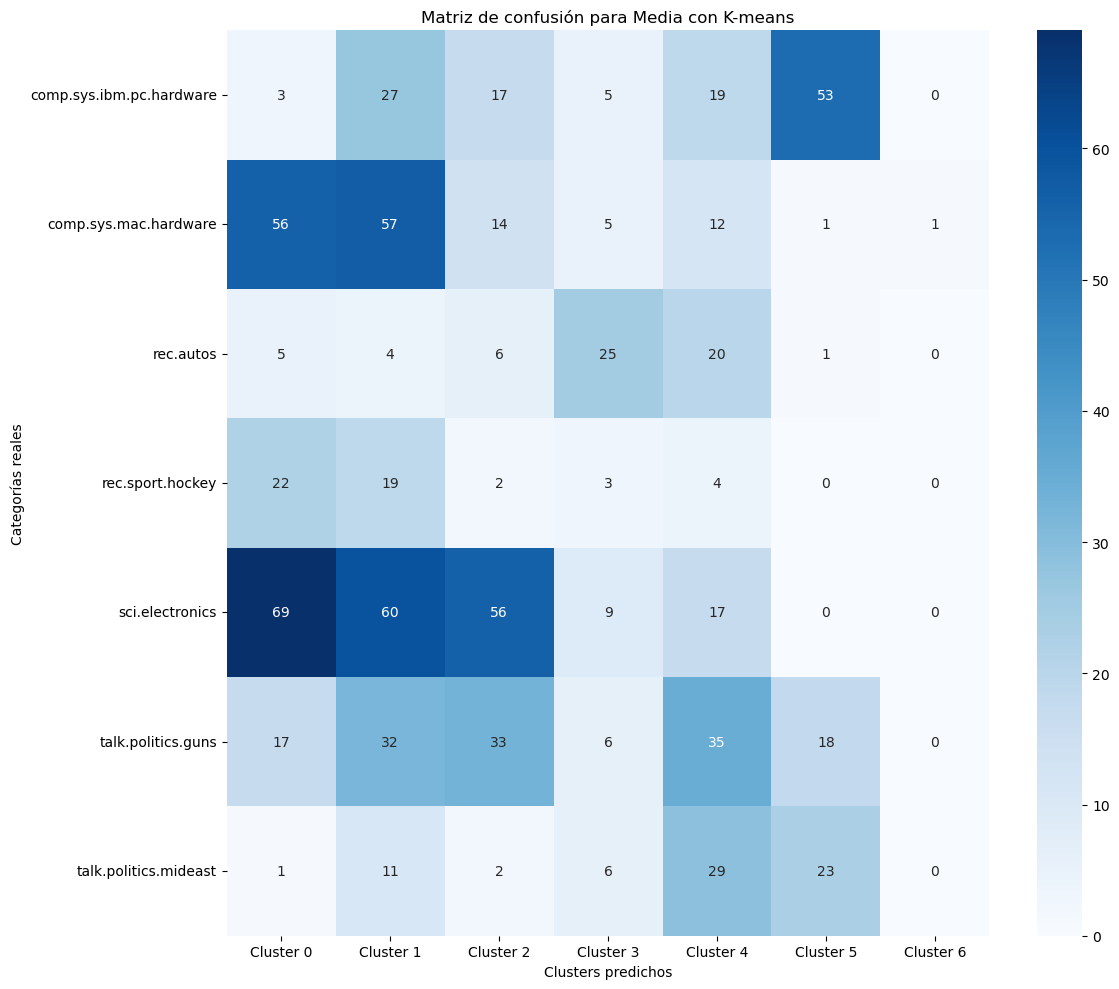


Análisis de la matriz de confusión para Matriz de confusión para Media con K-means:
Cluster 0 corresponde principalmente a 'sci.electronics' (39.9% de los documentos en este cluster)
Cluster 1 corresponde principalmente a 'sci.electronics' (28.6% de los documentos en este cluster)
Cluster 2 corresponde principalmente a 'sci.electronics' (43.1% de los documentos en este cluster)
Cluster 3 corresponde principalmente a 'rec.autos' (42.4% de los documentos en este cluster)
Cluster 4 corresponde principalmente a 'talk.politics.guns' (25.7% de los documentos en este cluster)
Cluster 5 corresponde principalmente a 'comp.sys.ibm.pc.hardware' (55.2% de los documentos en este cluster)
Cluster 6 corresponde principalmente a 'comp.sys.mac.hardware' (100.0% de los documentos en este cluster)

Distribución de categorías entre clusters:
Categoría 'comp.sys.ibm.pc.hardware': 42.7% en Cluster 5, dispersión: 0.57
  Distribución detallada:
    Cluster 5: 53 documentos (42.7%)
    Cluster 1: 27 documento

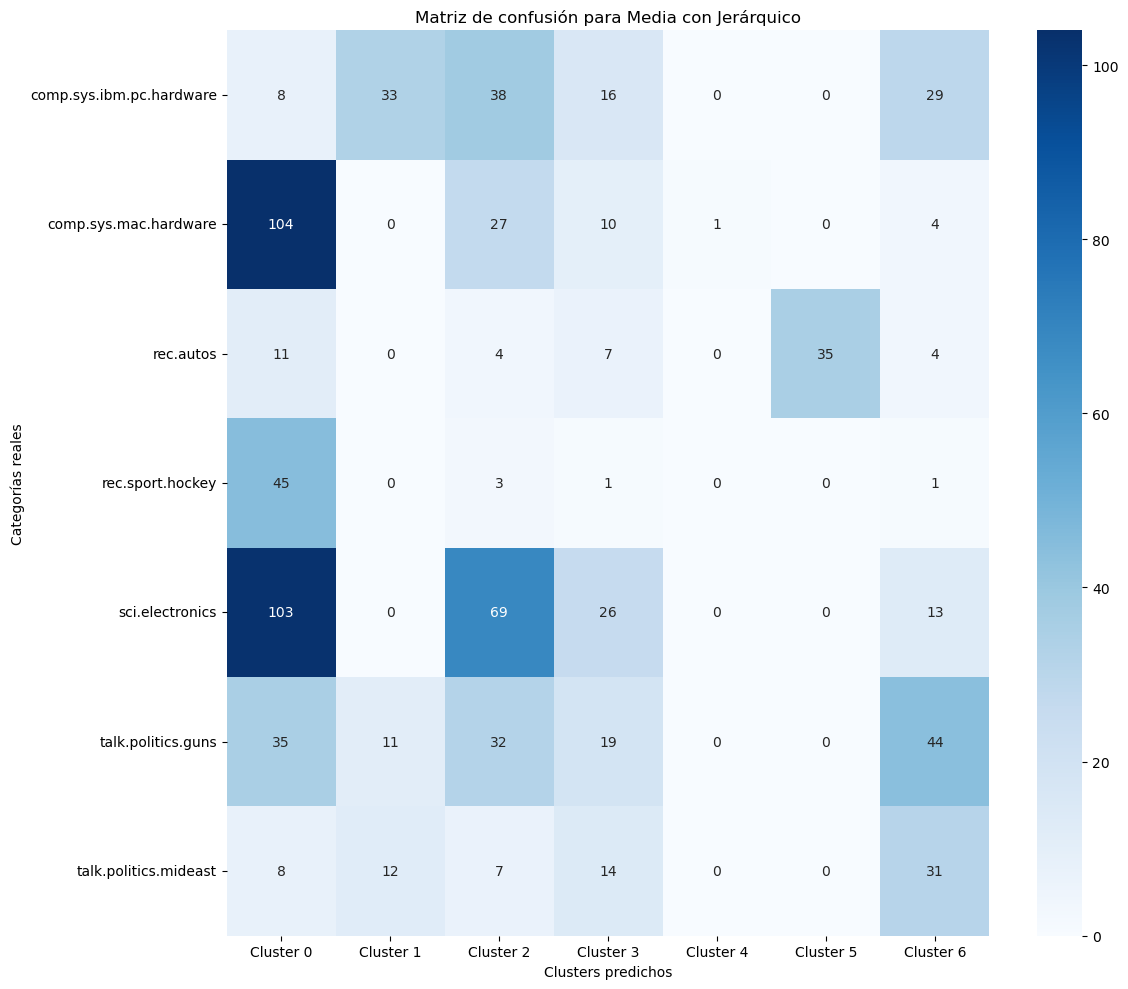


Análisis de la matriz de confusión para Matriz de confusión para Media con Jerárquico:
Cluster 0 corresponde principalmente a 'comp.sys.mac.hardware' (33.1% de los documentos en este cluster)
Cluster 1 corresponde principalmente a 'comp.sys.ibm.pc.hardware' (58.9% de los documentos en este cluster)
Cluster 2 corresponde principalmente a 'sci.electronics' (38.3% de los documentos en este cluster)
Cluster 3 corresponde principalmente a 'sci.electronics' (28.0% de los documentos en este cluster)
Cluster 4 corresponde principalmente a 'comp.sys.mac.hardware' (100.0% de los documentos en este cluster)
Cluster 5 corresponde principalmente a 'rec.autos' (100.0% de los documentos en este cluster)
Cluster 6 corresponde principalmente a 'talk.politics.guns' (34.9% de los documentos en este cluster)

Distribución de categorías entre clusters:
Categoría 'comp.sys.ibm.pc.hardware': 30.6% en Cluster 2, dispersión: 0.69
  Distribución detallada:
    Cluster 2: 38 documentos (30.6%)
    Cluster 1: 33

In [10]:
# Visualizamos la matriz de confusión para la mejor combinación
mejor_rep = mejor_combinacion['Representación']
mejor_alg = mejor_combinacion['Algoritmo']
clave_matriz = f"{mejor_rep}_{mejor_alg.replace('á', 'a')}"

visualizar_matriz_confusion(
    matrices_confusion[clave_matriz], 
    f"Matriz de confusión para {mejor_rep} con {mejor_alg}", 
    categorias_unicas,
    guardar=True,
    ruta_guardado=os.path.join(graficas_dir, f'matriz_confusion_mejor.png')
)

# Visualizamos las matrices de confusión para todas las combinaciones
for clave, matriz in matrices_confusion.items():
    partes = clave.split('_')
    rep = partes[0]
    alg = 'K-means' if partes[1] == 'Kmeans' else 'Jerárquico'
    
    # Guardamos todas las matrices de confusión
    ruta_guardado = os.path.join(graficas_dir, f'matriz_confusion_{rep}_{partes[1]}.png')
    
    visualizar_matriz_confusion(
        matriz, 
        f"Matriz de confusión para {rep} con {alg}", 
        categorias_unicas,
        guardar=True,
        ruta_guardado=ruta_guardado
    )

# Guardamos las matrices de confusión en formato numpy para posible análisis posterior
for clave, matriz in matrices_confusion.items():
    np.save(os.path.join(resultados_dir, f'matriz_confusion_{clave}.npy'), matriz)

print(f"\nTodos los resultados y visualizaciones han sido guardados en {resultados_dir} y {graficas_dir}")

Generando estadísticas comparativas...
Estadísticas comparativas guardadas en ./resultados_clustering

Promedio por algoritmo:


,ARI,BCubed Precision,BCubed Recall,BCubed F-score
Algoritmo,,,,
Jerárquico,0.070385,0.245759,0.658268,0.341715
K-means,0.050978,0.235621,0.537763,0.297701



Promedio por representación:


,ARI,BCubed Precision,BCubed Recall,BCubed F-score
Representación,,,,
Aditiva,0.035115,0.203493,0.642235,0.308889
Media,0.104531,0.273747,0.326099,0.296920
TF,0.007172,0.188247,0.939650,0.313623
TF-IDF,0.095908,0.297273,0.484077,0.359400



Diferencias entre algoritmos (Jerárquico - K-means):


,Diff ARI,Diff BCubed Precision,Diff BCubed Recall,Diff BCubed F-score
TF,0.003667,0.004395,-0.030683,0.004390
TF-IDF,-0.011631,-0.013273,0.284419,0.075255
Aditiva,0.056411,0.017866,0.126779,0.035315
Media,0.029181,0.031563,0.101508,0.061097


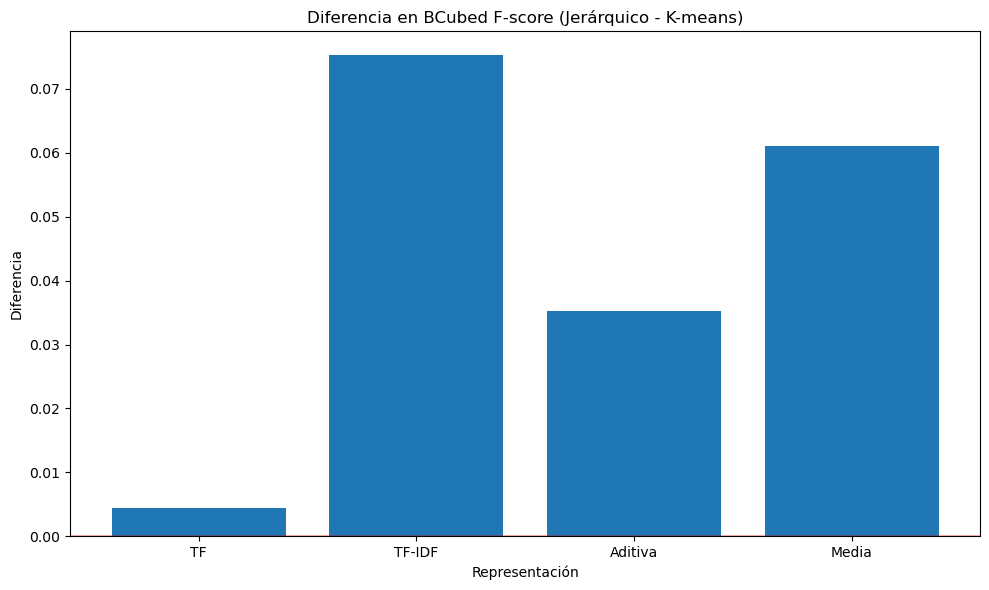

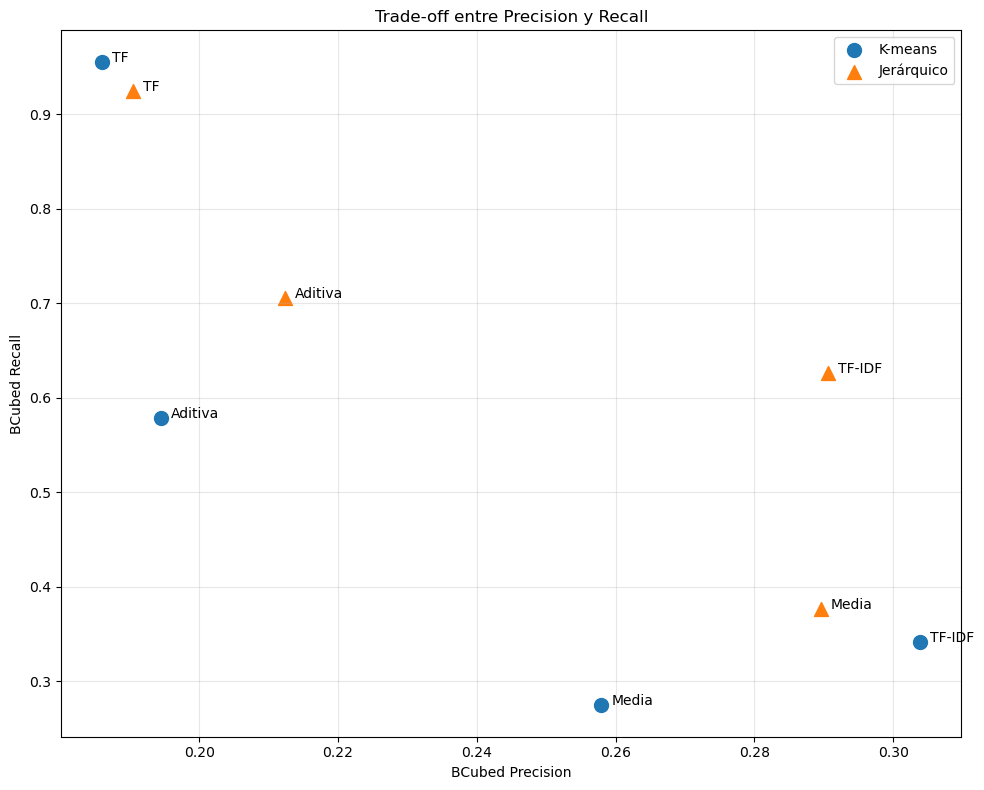

In [11]:
# Cálculos de promedios y agregaciones para análisis comparativo
def generar_estadisticas_comparativas(df_resultados, resultados_dir):
    """
    Genera estadísticas comparativas por algoritmo y representación
    """
    print("Generando estadísticas comparativas...")
    
    # Cálculo de promedios por algoritmo (solo columnas numéricas)
    df_por_algoritmo = df_resultados.groupby('Algoritmo')[['ARI', 'BCubed Precision', 'BCubed Recall', 'BCubed F-score']].mean()
    
    # Cálculo de promedios por representación (solo columnas numéricas)
    df_por_representacion = df_resultados.groupby('Representación')[['ARI', 'BCubed Precision', 'BCubed Recall', 'BCubed F-score']].mean()
    
    # Identificando máximos por métrica
    maximos = {
        'ARI': df_resultados.loc[df_resultados['ARI'].idxmax()],
        'BCubed Precision': df_resultados.loc[df_resultados['BCubed Precision'].idxmax()],
        'BCubed Recall': df_resultados.loc[df_resultados['BCubed Recall'].idxmax()],
        'BCubed F-score': df_resultados.loc[df_resultados['BCubed F-score'].idxmax()]
    }
    
    # Calculamos la diferencia entre algoritmos para cada representación
    diferencias = {}
    for rep in df_resultados['Representación'].unique():
        df_rep = df_resultados[df_resultados['Representación'] == rep]
        jerarquico = df_rep[df_rep['Algoritmo'] == 'Jerárquico'].iloc[0]
        kmeans = df_rep[df_rep['Algoritmo'] == 'K-means'].iloc[0]
        
        diferencias[rep] = {
            'Diff ARI': jerarquico['ARI'] - kmeans['ARI'],
            'Diff BCubed Precision': jerarquico['BCubed Precision'] - kmeans['BCubed Precision'],
            'Diff BCubed Recall': jerarquico['BCubed Recall'] - kmeans['BCubed Recall'],
            'Diff BCubed F-score': jerarquico['BCubed F-score'] - kmeans['BCubed F-score']
        }
    
    # Guardamos los resultados
    df_por_algoritmo.to_csv(os.path.join(resultados_dir, 'resultados_por_algoritmo.csv'))
    df_por_representacion.to_csv(os.path.join(resultados_dir, 'resultados_por_representacion.csv'))
    
    # Guardamos información de máximos
    with open(os.path.join(resultados_dir, 'maximos_por_metrica.txt'), 'w') as f:
        for metrica, info in maximos.items():
            f.write(f"Máximo {metrica}:\n")
            f.write(f"  Representación: {info['Representación']}\n")
            f.write(f"  Algoritmo: {info['Algoritmo']}\n")
            f.write(f"  Valor: {info[metrica]:.4f}\n\n")
    
    # Guardamos diferencias entre algoritmos
    df_diferencias = pd.DataFrame.from_dict(diferencias, orient='index')
    df_diferencias.to_csv(os.path.join(resultados_dir, 'diferencias_entre_algoritmos.csv'))
    
    # Creamos una visualización de las diferencias
    plt.figure(figsize=(10, 6))
    plt.bar(df_diferencias.index, df_diferencias['Diff BCubed F-score'])
    plt.title('Diferencia en BCubed F-score (Jerárquico - K-means)')
    plt.ylabel('Diferencia')
    plt.xlabel('Representación')
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(graficas_dir, 'diferencias_fscore.png'), dpi=150)
    
    # Visualizamos el trade-off entre precision y recall
    plt.figure(figsize=(10, 8))
    for algoritmo, marker in [('K-means', 'o'), ('Jerárquico', '^')]:
        df_alg = df_resultados[df_resultados['Algoritmo'] == algoritmo]
        plt.scatter(
            df_alg['BCubed Precision'], 
            df_alg['BCubed Recall'], 
            s=100, 
            marker=marker,
            label=algoritmo
        )
        # Añadimos etiquetas para cada punto
        for idx, row in df_alg.iterrows():
            plt.annotate(
                row['Representación'], 
                (row['BCubed Precision'], row['BCubed Recall']),
                xytext=(7, 0), 
                textcoords='offset points'
            )
    
    plt.title('Trade-off entre Precision y Recall')
    plt.xlabel('BCubed Precision')
    plt.ylabel('BCubed Recall')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(graficas_dir, 'tradeoff_precision_recall.png'), dpi=150)
    
    print(f"Estadísticas comparativas guardadas en {resultados_dir}")
    return df_por_algoritmo, df_por_representacion, maximos, df_diferencias

# Ejecutamos la función con los resultados obtenidos
df_por_algoritmo, df_por_representacion, maximos, df_diferencias = generar_estadisticas_comparativas(df_resultados, resultados_dir)

# Mostramos los promedios por algoritmo
print("\nPromedio por algoritmo:")
display(df_por_algoritmo)

# Mostramos los promedios por representación
print("\nPromedio por representación:")
display(df_por_representacion)

# Mostramos las diferencias entre algoritmos
print("\nDiferencias entre algoritmos (Jerárquico - K-means):")
display(df_diferencias)



ANÁLISIS COMPLEMENTARIO: LEMATIZACIÓN VS TRUNCAMIENTO

Representación aditiva con lematización cargada: (805, 50)
Representación media con lematización cargada: (805, 50)

Procesando representación: Aditiva_Lematizacion
Aplicando K-means...
K-means - ARI: 0.0031, BCubed Precision: 0.1925, BCubed Recall: 0.5816, BCubed F-score: 0.2892
Aplicando Clustering Jerárquico Aglomerativo...
Jerárquico - ARI: 0.0081, BCubed Precision: 0.1923, BCubed Recall: 0.9265, BCubed F-score: 0.3186

Procesando representación: Media_Lematizacion
Aplicando K-means...
K-means - ARI: 0.1108, BCubed Precision: 0.2891, BCubed Recall: 0.2701, BCubed F-score: 0.2793
Aplicando Clustering Jerárquico Aglomerativo...
Jerárquico - ARI: 0.1381, BCubed Precision: 0.3309, BCubed Recall: 0.3708, BCubed F-score: 0.3497

Resultados con lematización:


,Representación,Algoritmo,ARI,BCubed Precision,BCubed Recall,BCubed F-score
0,Aditiva_Lematizacion,K-means,0.003132,0.192456,0.581626,0.289213
1,Aditiva_Lematizacion,Jerárquico,0.008063,0.192347,0.926459,0.318556
2,Media_Lematizacion,K-means,0.110802,0.289137,0.270100,0.279295
3,Media_Lematizacion,Jerárquico,0.138089,0.330897,0.370834,0.349729


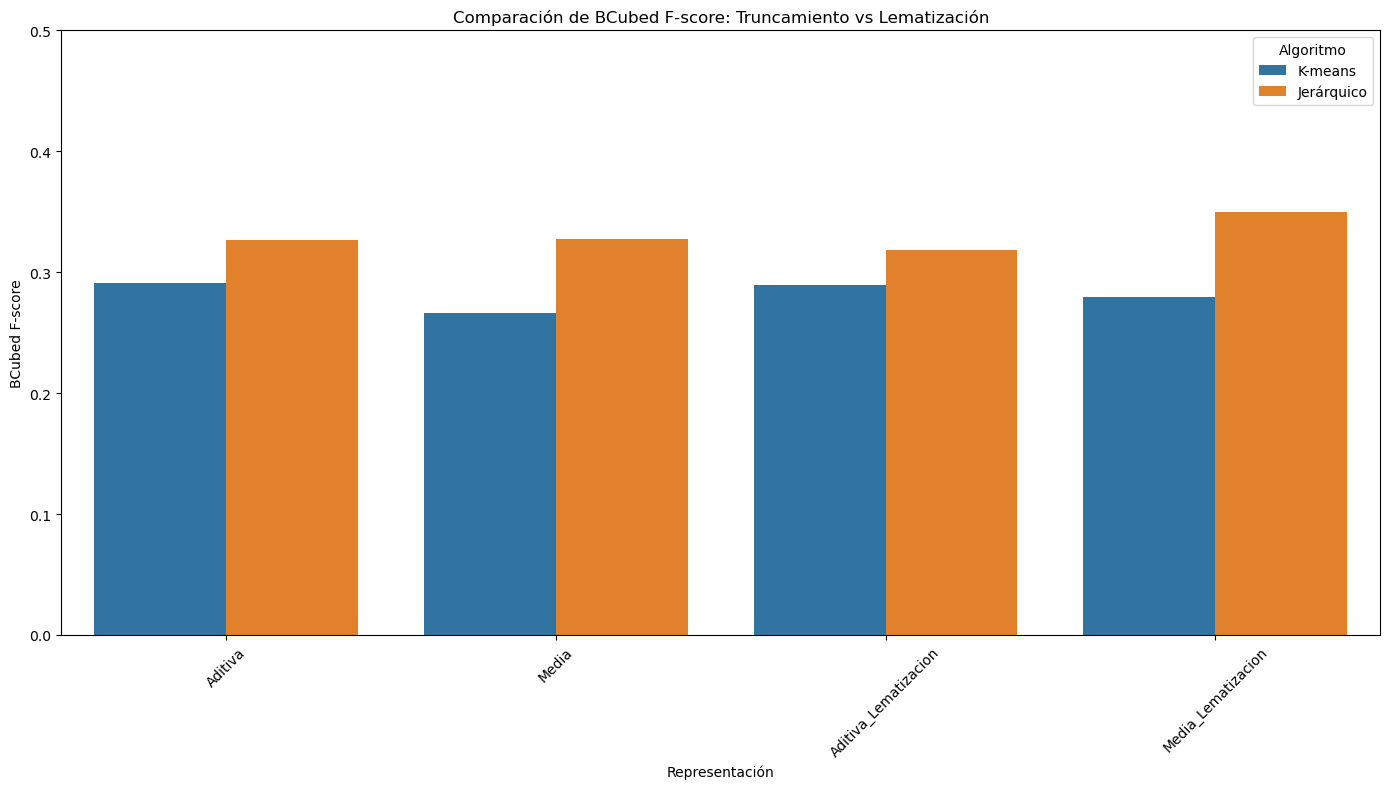


Mejora porcentual con lematización:
Algoritmo K-means:
  Aditiva: -0.69% (0.2912 → 0.2892)
  Media: 4.85% (0.2664 → 0.2793)
Algoritmo Jerárquico:
  Aditiva: -2.45% (0.3265 → 0.3186)
  Media: 6.80% (0.3275 → 0.3497)

Mejor combinación con lematización:
Representación: Media_Lematizacion
Algoritmo: Jerárquico
BCubed F-score: 0.3497

Matriz de confusión para la mejor combinación con lematización:
Matriz de confusión guardada en ./resultados_clustering/graficas/matriz_confusion_mejor_lematizacion.png


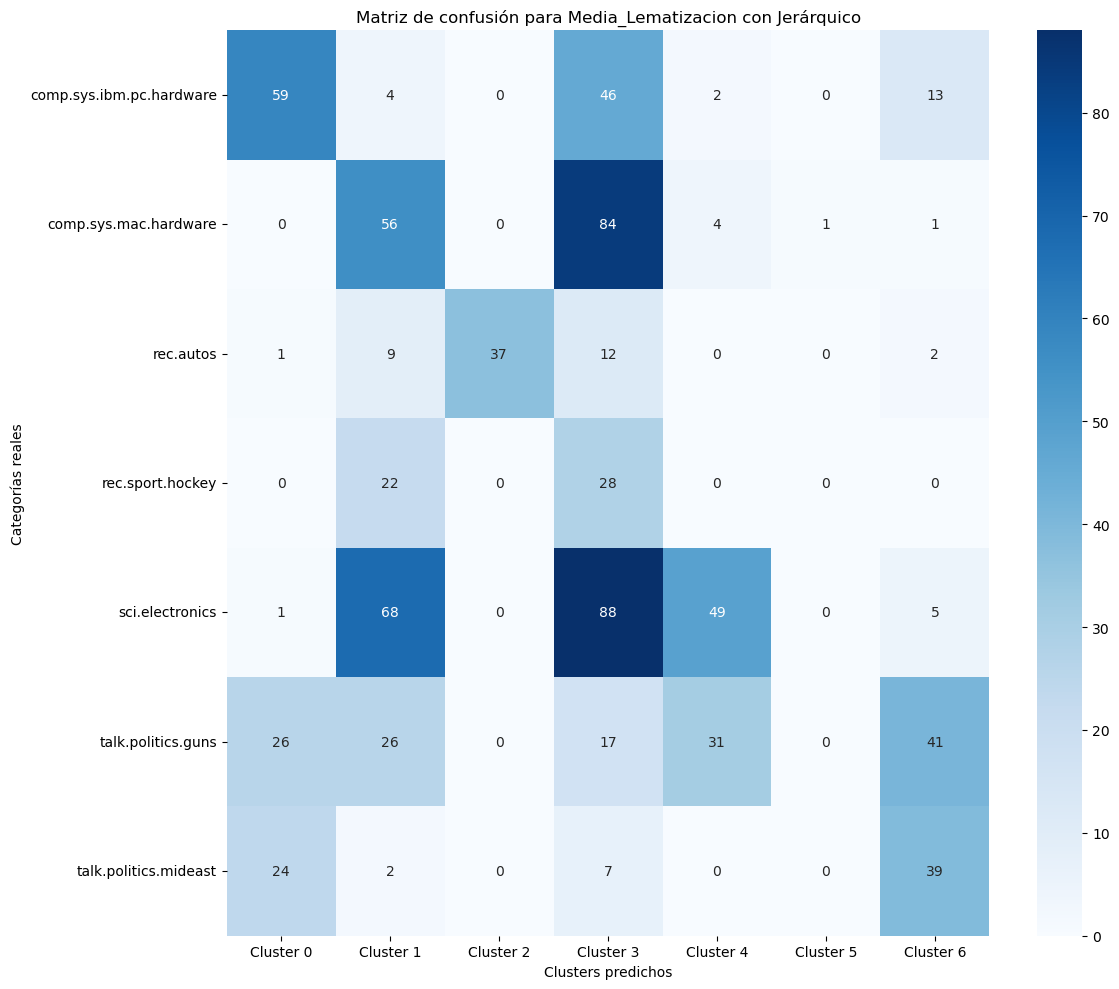


Análisis de la matriz de confusión para Matriz de confusión para Media_Lematizacion con Jerárquico:
Cluster 0 corresponde principalmente a 'comp.sys.ibm.pc.hardware' (53.2% de los documentos en este cluster)
Cluster 1 corresponde principalmente a 'sci.electronics' (36.4% de los documentos en este cluster)
Cluster 2 corresponde principalmente a 'rec.autos' (100.0% de los documentos en este cluster)
Cluster 3 corresponde principalmente a 'sci.electronics' (31.2% de los documentos en este cluster)
Cluster 4 corresponde principalmente a 'sci.electronics' (57.0% de los documentos en este cluster)
Cluster 5 corresponde principalmente a 'comp.sys.mac.hardware' (100.0% de los documentos en este cluster)
Cluster 6 corresponde principalmente a 'talk.politics.guns' (40.6% de los documentos en este cluster)

Distribución de categorías entre clusters:
Categoría 'comp.sys.ibm.pc.hardware': 47.6% en Cluster 0, dispersión: 0.52
  Distribución detallada:
    Cluster 0: 59 documentos (47.6%)
    Cluste

([{'Cluster': 0,
   'Categoría principal': 'comp.sys.ibm.pc.hardware',
   'Porcentaje': 53.153153153153156},
  {'Cluster': 1,
   'Categoría principal': 'sci.electronics',
   'Porcentaje': 36.36363636363637},
  {'Cluster': 2, 'Categoría principal': 'rec.autos', 'Porcentaje': 100.0},
  {'Cluster': 3,
   'Categoría principal': 'sci.electronics',
   'Porcentaje': 31.20567375886525},
  {'Cluster': 4,
   'Categoría principal': 'sci.electronics',
   'Porcentaje': 56.97674418604651},
  {'Cluster': 5,
   'Categoría principal': 'comp.sys.mac.hardware',
   'Porcentaje': 100.0},
  {'Cluster': 6,
   'Categoría principal': 'talk.politics.guns',
   'Porcentaje': 40.5940594059406}],
 [{'Categoría': 'comp.sys.ibm.pc.hardware',
   'Cluster principal': 0,
   'Porcentaje': 47.58064516129033,
   'Dispersión': 0.5241935483870968,
   'Distribución detallada': ['Cluster 0: 59 documentos (47.6%)',
    'Cluster 3: 46 documentos (37.1%)',
    'Cluster 6: 13 documentos (10.5%)']},
  {'Categoría': 'comp.sys.mac.ha

In [12]:
# Análisis complementario: impacto de la lematización en modelos semánticos vectoriales
print("\n\n============================================================")
print("ANÁLISIS COMPLEMENTARIO: LEMATIZACIÓN VS TRUNCAMIENTO")
print("============================================================\n")

def cargar_representaciones_lematizacion(ruta_base):
    """
    Carga las representaciones generadas con lematización para el modelo semántico vectorial
    """
    representaciones_lem = {}
    
    # Intentamos cargar representación aditiva con lematización
    try:
        rep_aditiva_lem = np.loadtxt(os.path.join(ruta_base, 'representacion_aditiva_lematizacion.txt'), delimiter='\t')
        representaciones_lem['Aditiva_Lematizacion'] = rep_aditiva_lem
        print(f"Representación aditiva con lematización cargada: {rep_aditiva_lem.shape}")
    except Exception as e:
        print(f"Error al cargar representación aditiva con lematización: {e}")
    
    # Intentamos cargar representación media con lematización
    try:
        rep_media_lem = np.loadtxt(os.path.join(ruta_base, 'representacion_media_lematizacion.txt'), delimiter='\t')
        representaciones_lem['Media_Lematizacion'] = rep_media_lem
        print(f"Representación media con lematización cargada: {rep_media_lem.shape}")
    except Exception as e:
        print(f"Error al cargar representación media con lematización: {e}")
    
    return representaciones_lem

# Cargamos las representaciones con lematización
representaciones_lem = cargar_representaciones_lematizacion(ruta_resultados)

# Aplicamos clustering a las representaciones con lematización
resultados_lem = []
matrices_confusion_lem = {}
etiquetas_clustering_lem = {}
etiquetas_reales = goldstandard['categoria_id'].values

for nombre_rep, rep in representaciones_lem.items():
    print(f"\nProcesando representación: {nombre_rep}")
    
    # Normalizamos los datos para las representaciones basadas en word embeddings
    scaler = StandardScaler()
    datos = scaler.fit_transform(rep)
    
    # Aplicamos K-means
    print("Aplicando K-means...")
    kmeans = KMeans(n_clusters=7, random_state=42, n_init=10)
    etiquetas_kmeans = kmeans.fit_predict(datos)
    etiquetas_clustering_lem[f"{nombre_rep}_Kmeans"] = etiquetas_kmeans
    
    # Evaluamos K-means
    ari_kmeans = adjusted_rand_score(etiquetas_reales, etiquetas_kmeans)
    precision_kmeans, recall_kmeans, fscore_kmeans = bcubed_precision_recall_fscore(etiquetas_reales, etiquetas_kmeans)
    
    print(f"K-means - ARI: {ari_kmeans:.4f}, BCubed Precision: {precision_kmeans:.4f}, BCubed Recall: {recall_kmeans:.4f}, BCubed F-score: {fscore_kmeans:.4f}")
    
    # Guardamos los resultados de K-means
    resultados_lem.append({
        'Representación': nombre_rep,
        'Algoritmo': 'K-means',
        'ARI': ari_kmeans,
        'BCubed Precision': precision_kmeans,
        'BCubed Recall': recall_kmeans,
        'BCubed F-score': fscore_kmeans
    })
    
    # Guardamos la matriz de confusión para K-means
    matrices_confusion_lem[f"{nombre_rep}_Kmeans"] = confusion_matrix(etiquetas_reales, etiquetas_kmeans)
    
    # Aplicamos Clustering Jerárquico Aglomerativo
    print("Aplicando Clustering Jerárquico Aglomerativo...")
    agglom = AgglomerativeClustering(n_clusters=7, linkage='ward')
    etiquetas_agglom = agglom.fit_predict(datos)
    etiquetas_clustering_lem[f"{nombre_rep}_Jerarquico"] = etiquetas_agglom
    
    # Evaluamos Clustering Jerárquico
    ari_agglom = adjusted_rand_score(etiquetas_reales, etiquetas_agglom)
    precision_agglom, recall_agglom, fscore_agglom = bcubed_precision_recall_fscore(etiquetas_reales, etiquetas_agglom)
    
    print(f"Jerárquico - ARI: {ari_agglom:.4f}, BCubed Precision: {precision_agglom:.4f}, BCubed Recall: {recall_agglom:.4f}, BCubed F-score: {fscore_agglom:.4f}")
    
    # Guardamos los resultados del Clustering Jerárquico
    resultados_lem.append({
        'Representación': nombre_rep,
        'Algoritmo': 'Jerárquico',
        'ARI': ari_agglom,
        'BCubed Precision': precision_agglom,
        'BCubed Recall': recall_agglom,
        'BCubed F-score': fscore_agglom
    })
    
    # Guardamos la matriz de confusión para Clustering Jerárquico
    matrices_confusion_lem[f"{nombre_rep}_Jerarquico"] = confusion_matrix(etiquetas_reales, etiquetas_agglom)

# Convertimos los resultados a DataFrame
df_resultados_lem = pd.DataFrame(resultados_lem)

# Mostramos los resultados
print("\nResultados con lematización:")
display(df_resultados_lem)

# Unimos los resultados con los originales para comparación
# Filtramos solo las representaciones relacionadas con word embeddings
df_resultados_orig = df_resultados[df_resultados['Representación'].isin(['Aditiva', 'Media'])]
df_resultados_combinados = pd.concat([df_resultados_orig, df_resultados_lem])

# Realizamos una comparación visual
plt.figure(figsize=(14, 8))
sns.barplot(x='Representación', y='BCubed F-score', hue='Algoritmo', data=df_resultados_combinados)
plt.title('Comparación de BCubed F-score: Truncamiento vs Lematización')
plt.ylim(0, 0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(graficas_dir, 'comparacion_lematizacion.png'), dpi=300)
plt.show()

# Calculamos las mejoras porcentuales
print("\nMejora porcentual con lematización:")
for algoritmo in ['K-means', 'Jerárquico']:
    # Aditiva
    aditiva_orig = df_resultados_orig[(df_resultados_orig['Representación'] == 'Aditiva') & 
                                      (df_resultados_orig['Algoritmo'] == algoritmo)]['BCubed F-score'].values[0]
    aditiva_lem = df_resultados_lem[(df_resultados_lem['Representación'] == 'Aditiva_Lematizacion') & 
                                   (df_resultados_lem['Algoritmo'] == algoritmo)]['BCubed F-score'].values[0]
    mejora_aditiva = (aditiva_lem - aditiva_orig) / aditiva_orig * 100
    
    # Media
    media_orig = df_resultados_orig[(df_resultados_orig['Representación'] == 'Media') & 
                                   (df_resultados_orig['Algoritmo'] == algoritmo)]['BCubed F-score'].values[0]
    media_lem = df_resultados_lem[(df_resultados_lem['Representación'] == 'Media_Lematizacion') & 
                                 (df_resultados_lem['Algoritmo'] == algoritmo)]['BCubed F-score'].values[0]
    mejora_media = (media_lem - media_orig) / media_orig * 100
    
    print(f"Algoritmo {algoritmo}:")
    print(f"  Aditiva: {mejora_aditiva:.2f}% ({aditiva_orig:.4f} → {aditiva_lem:.4f})")
    print(f"  Media: {mejora_media:.2f}% ({media_orig:.4f} → {media_lem:.4f})")

# Visualizamos también una matriz de confusión para la mejor combinación con lematización
mejor_combinacion_lem = df_resultados_lem.loc[df_resultados_lem['BCubed F-score'].idxmax()]
print(f"\nMejor combinación con lematización:")
print(f"Representación: {mejor_combinacion_lem['Representación']}")
print(f"Algoritmo: {mejor_combinacion_lem['Algoritmo']}")
print(f"BCubed F-score: {mejor_combinacion_lem['BCubed F-score']:.4f}")

clave_matriz_lem = f"{mejor_combinacion_lem['Representación']}_{mejor_combinacion_lem['Algoritmo'].replace('á', 'a')}"

print(f"\nMatriz de confusión para la mejor combinación con lematización:")
visualizar_matriz_confusion(
    matrices_confusion_lem[clave_matriz_lem], 
    f"Matriz de confusión para {mejor_combinacion_lem['Representación']} con {mejor_combinacion_lem['Algoritmo']}", 
    categorias_unicas,
    guardar=True,
    ruta_guardado=os.path.join(graficas_dir, f'matriz_confusion_mejor_lematizacion.png')
)